In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import jax.numpy as jnp
import numpy as np
import os
from matplotlib import pyplot as plt
from pathlib import Path


import sys
sys.path.append('../')
import field_level.inference as inference

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

INFO:2025-08-26 05:45:53,258:jax._src.xla_bridge:945: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-08-26 05:45:53,258 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-08-26 05:45:53,260:jax._src.xla_bridge:945: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-08-26 05:45:53,260 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-08-26 05:45:53,270 INFO: The inference is running on gpu


NVIDIA H200
NVIDIA H200
NVIDIA H200
NVIDIA H200
NVIDIA H200
NVIDIA H200
NVIDIA H200
NVIDIA H200


/opt/sns/anaconda3/2024.06/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### Example of the field-level inference for the linear Gaussian field with $64^3$ ICs in 2.0 $\mathrm{Gpc}/h$ box and $k_\mathrm{max}=0.1~h/\mathrm{Mpc}$

In [2]:
### parameters

boxsize = 2000.0
redshift = 0.5
which_pk = 'cosmo'

data_path = f'../mock_data/{which_pk}_{boxsize}_z{redshift}_gauss_8.0_128.npy'
save_path = './results/gauss'
if not os.path.exists('./results'):
    os.mkdir('./results')

#ics_params = ['varied_ics', 0] 
ics_params = ['varied_ics', 0] 
### 0 specifies not saving the samples of modes, if you set 1 the samples of modes are also saved (but be careful that its size would be huge).

model_name = 'gauss'

ng_params = [64, 64, 64] 
### the number of ICs, the number of particles, and the number of assignment grid

mas_params = [2, 1]
### the interpolation order of assignment, and the interlace or not. Again, this is not relevant for the eulerian run (including gaussian run)

which_space = 'k_space'
### In which space the likelihood is evaluated.

cosmo_params = {'A':(0.5 ,1.5), 'oc': (0.05, 0.255), 'hubble': (0.64, 0.82)}
#cosmo_params = {'A':(0.5 ,1.5), 'oc': 0.11933, 'hubble': 0.73}

bias_params = {}

err_params = {'log_Perr':8.0}
### for the fixed value of the noise in the likelihood. If you would like to vary it, set 'log_Perr':(mean, std).

kmax = 0.1

dense_mass = [('A', 'scaled_oc', 'scaled_hubble')]
#dense_mass = [('A',)]

#mcmc_params = [0, 4, 1, 10000, 1000, 0.8, 2004, 0]
mcmc_params = [0, 8, 1, 1000, 500, 0.8, 2004, 0]
### i-th chain, the number of chains, thinning, the number of samples, the number of warmup, the target acceptance rate, random seed for mcmc, and the number of the previously collected samples divied by 100 (to restart)



In [3]:
### run inferencne

inference.field_inference(boxsize, redshift, which_pk,
                          data_path, save_path,
                          ics_params,
                          model_name, ng_params, mas_params, which_space,
                          cosmo_params, bias_params, err_params, kmax,
                          dense_mass, mcmc_params)

2025-08-26 05:45:53,565 INFO: Initial IC settings: varied_ics
2025-08-26 05:45:54,127 INFO: cic interlacing on
2025-08-26 05:45:54,128 INFO: ng = 64, ng_L = 64, ng_E = 64, kmax = 0.1
2025-08-26 05:45:54,128 INFO: Parsed model: ModelSpec(fwd_kind='gauss', lpt_order=0, pt_order=1, bias_order=0, rsd=False, matter=False)
2025-08-26 05:45:55,682 INFO: idx_conjugate_real_kmax.shape = (67647,)
2025-08-26 05:45:55,683 INFO: idx_conjugate_imag_kmax.shape = (67647,)
2025-08-26 05:45:55,684 INFO: Loading data from ../mock_data/cosmo_2000.0_z0.5_gauss_8.0_128.npy
2025-08-26 05:45:55,689 INFO: Data loaded successfully.
2025-08-26 05:45:55,783 INFO: data_1d_ind.shape = (135042,)
2025-08-26 05:45:55,784 INFO: dense_mass = [('A',)]
2025-08-26 05:46:11,322 INFO: params = ['A', 'H0', 'OM', 'hubble', 'oc', 'scaled_hubble', 'scaled_oc', 'sigma8', 'potential_energy']
2025-08-26 05:46:11,323 INFO: MAP_params = ['A', 'H0', 'OM', 'gauss_1d', 'hubble', 'oc', 'scaled_hubble', 'scaled_oc', 'sigma8', 'potential_e

In [5]:
from field_level.inference import load_samples_npz

save_base = "./results/gauss"
chain_ids = [0, 1, 2, 3, 4, 5, 6, 7]

# Probe the first chain to define shapes and keys ---
first_fn = f"{save_base}_samples_chain{chain_ids[0]}.npz"
if not Path(first_fn).exists():
    raise FileNotFoundError(first_fn)

samples0, map0, _ = load_samples_npz(first_fn)

# Keep only per-sample scalar params: arrays with shape (N,)
scalar_keys = [k for k, v in samples0.items() if isinstance(v, np.ndarray) and v.ndim == 1]
if not scalar_keys:
    raise RuntimeError("No scalar-by-sample parameters found in the file.")

num_samples = samples0[scalar_keys[0]].shape[0]
num_chains = len(chain_ids)

# MAP scalars: 0-d arrays (scalars)
map_scalar_keys = [k for k, v in map0.items() if np.asarray(v).ndim == 0]

# Preallocate outputs
samples = {k: np.empty((num_chains, num_samples), dtype=np.float32) for k in scalar_keys}
map_samples = {k: np.empty((num_chains,), dtype=np.float32) for k in map_scalar_keys}

# Load each chain and stack ---
for i, cid in enumerate(chain_ids):
    fn = f"{save_base}_samples_chain{cid}.npz"
    s_c, m_c, _ = load_samples_npz(fn)

    # Fill sample arrays (assert same length/shape as the first chain)
    for k in scalar_keys:
        arr = np.asarray(s_c[k])
        # Optional strict checks (can be removed if you fully trust consistency)
        if arr.ndim != 1 or arr.shape[0] != num_samples:
            raise ValueError(f"Shape mismatch for '{k}' in chain {cid}: {arr.shape} != ({num_samples},)")
        samples[k][i, :] = arr.astype(np.float32, copy=False)

    # Fill MAP scalars
    for k in map_scalar_keys:
        map_samples[k][i] = float(np.asarray(m_c[k]).reshape(()))

print(f"Loaded {len(scalar_keys)} scalar params with shape (chains={num_chains}, samples={num_samples}).")
print(f"Loaded {len(map_scalar_keys)} MAP scalars with shape (chains={num_chains},).")

# Quick peek
for k in scalar_keys[:8]:
    print(k, samples[k])
for k in map_scalar_keys[:8]:
    print("MAP", k, map_samples[k])


Loaded 9 scalar params with shape (chains=8, samples=1000).
Loaded 9 MAP scalars with shape (chains=8,).
A [[1.0208731  1.0079229  1.0152988  ... 0.9879248  0.98675907 0.99203324]
 [1.0528717  1.0409532  1.0449123  ... 1.0530747  1.0376811  1.040284  ]
 [1.0116363  1.0213089  1.0076861  ... 1.0108895  1.0134397  1.0172236 ]
 ...
 [0.98970854 1.009624   1.016347   ... 1.0154604  1.0304191  1.0263762 ]
 [0.99156857 0.99770224 1.0393777  ... 1.0199109  1.0139145  1.0106037 ]
 [1.0289199  1.0093782  0.99945545 ... 1.003818   1.0302343  0.9873711 ]]
H0 [[72.10894  72.709404 72.334076 ... 74.55252  73.5329   72.66646 ]
 [69.62558  71.719185 70.31247  ... 69.60331  70.90582  70.80812 ]
 [72.417625 71.43728  72.754364 ... 72.284515 71.803055 70.95691 ]
 ...
 [73.20353  71.908905 72.371254 ... 71.868385 71.031395 71.49177 ]
 [73.48833  73.37337  69.97378  ... 72.41791  72.73203  72.7036  ]
 [71.93832  73.551575 73.59545  ... 72.60866  70.49567  74.67581 ]]
OM [[0.2631515  0.26614842 0.26428905 

array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'H0'}>, <Axes: title={'center': 'H0'}>],
       [<Axes: title={'center': 'OM'}>, <Axes: title={'center': 'OM'}>],
       [<Axes: title={'center': 'hubble'}>,
        <Axes: title={'center': 'hubble'}>],
       [<Axes: title={'center': 'oc'}>, <Axes: title={'center': 'oc'}>],
       [<Axes: title={'center': 'scaled_hubble'}>,
        <Axes: title={'center': 'scaled_hubble'}>],
       [<Axes: title={'center': 'scaled_oc'}>,
        <Axes: title={'center': 'scaled_oc'}>],
       [<Axes: title={'center': 'sigma8'}>,
        <Axes: title={'center': 'sigma8'}>],
       [<Axes: title={'center': 'potential_energy'}>,
        <Axes: title={'center': 'potential_energy'}>]], dtype=object)

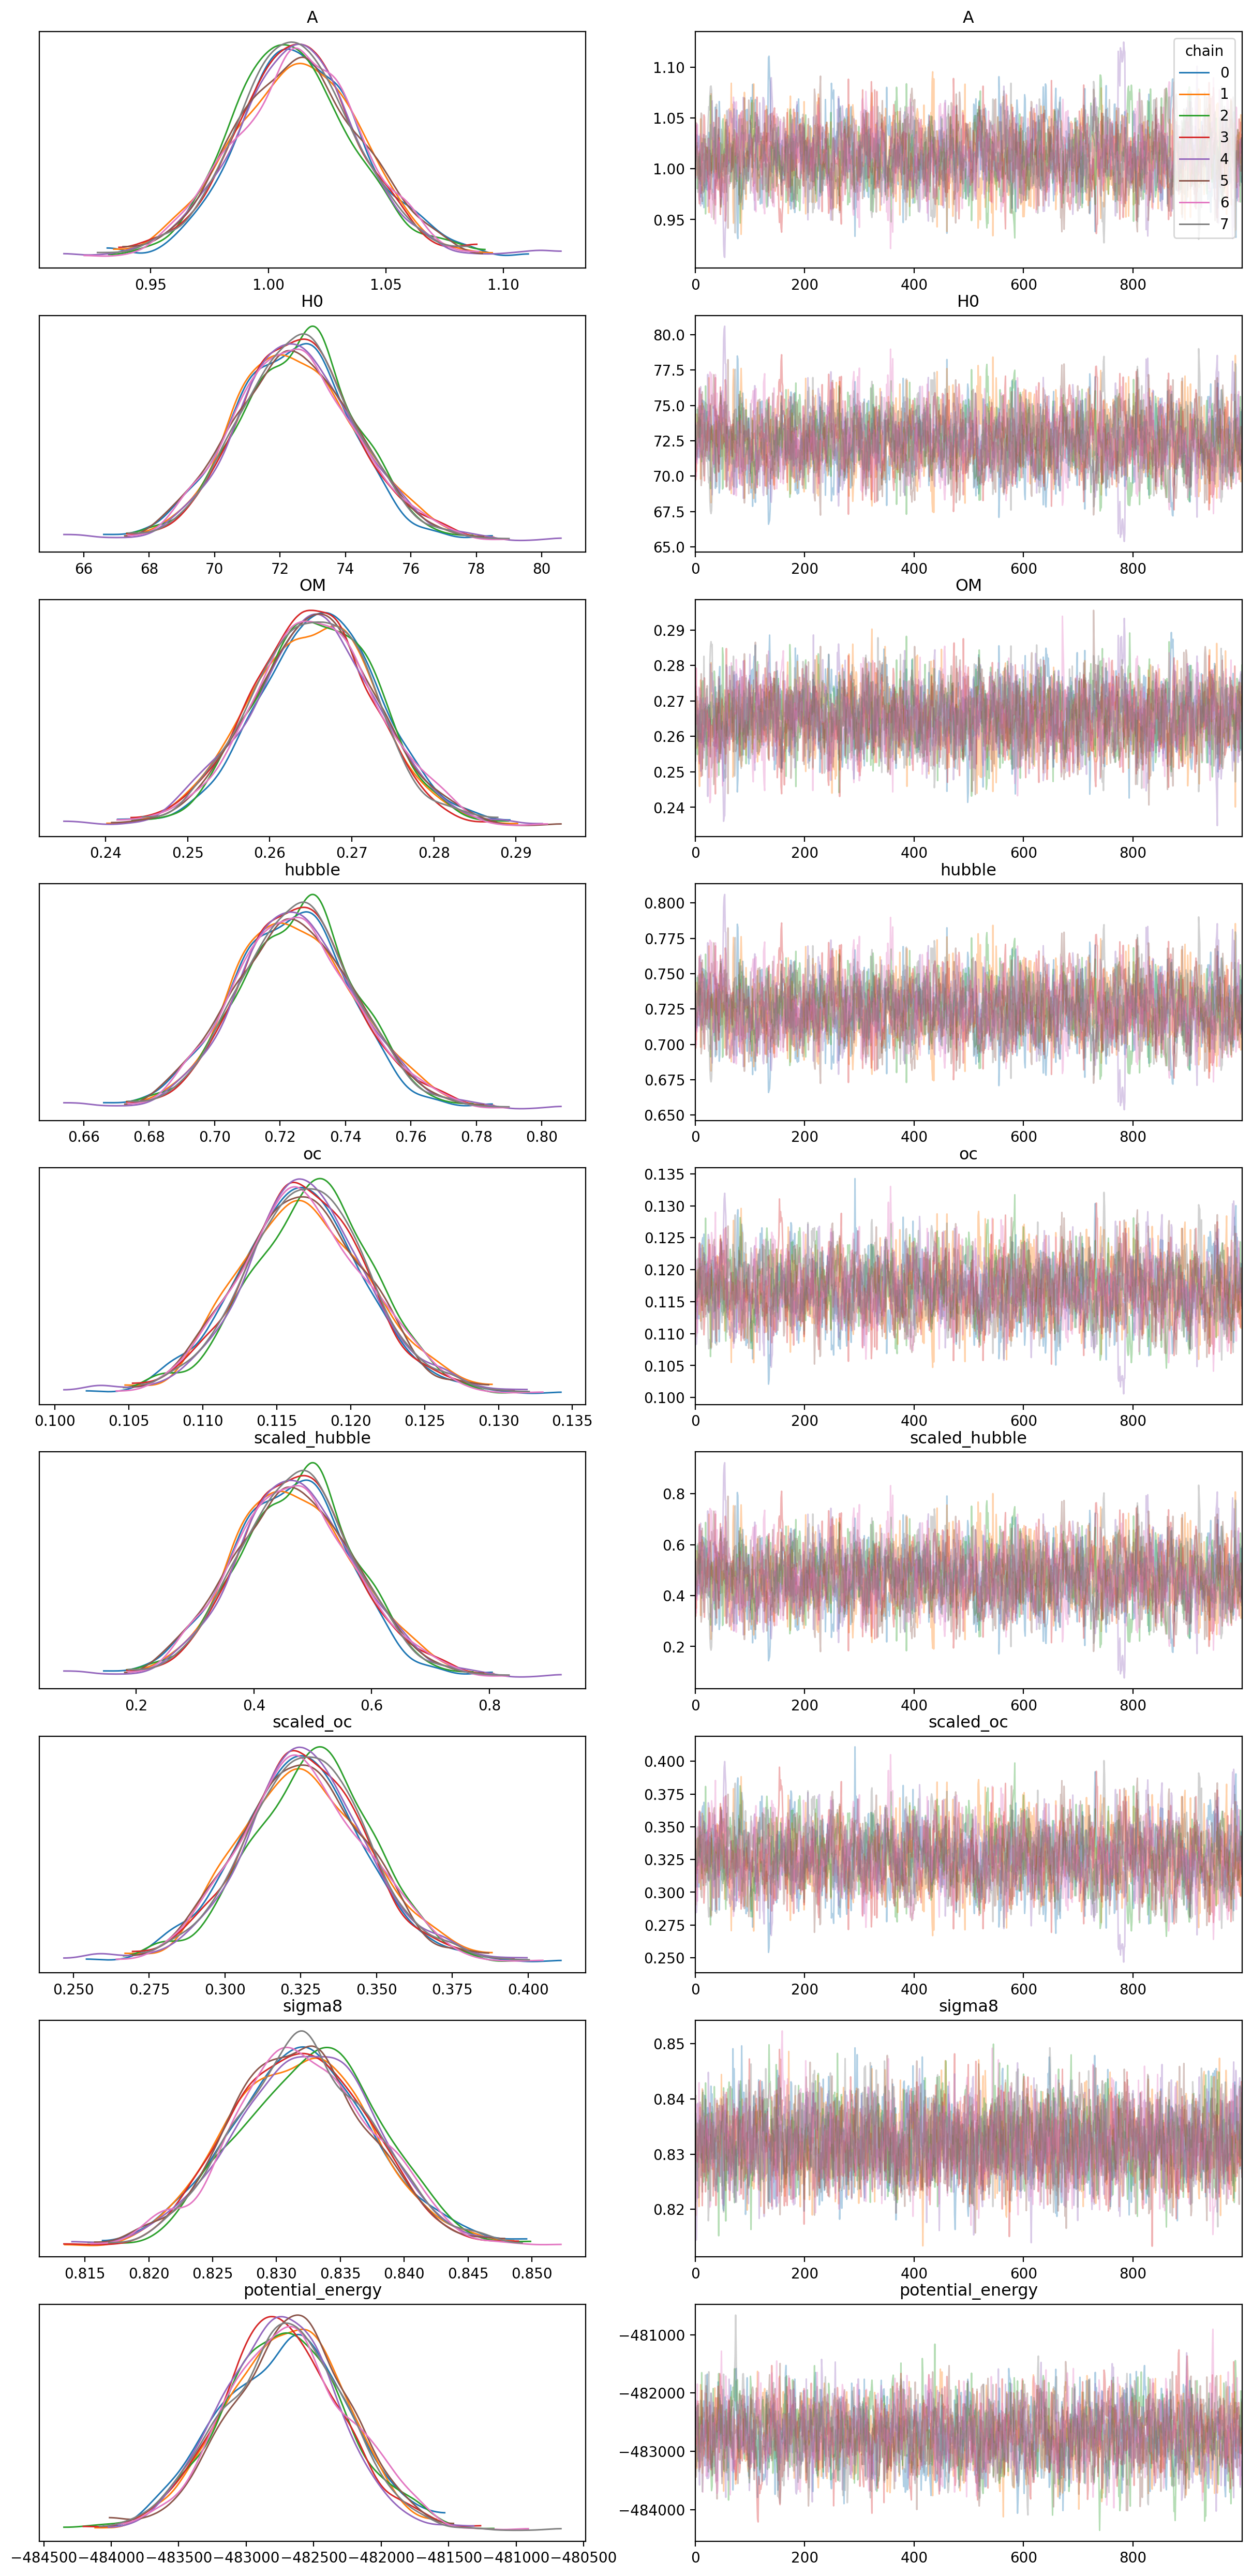

In [6]:
import arviz as az

az.plot_trace(samples, legend=True, compact=False, figsize=(15,3.5*len(samples)))

In [7]:
params = ['A', 'oc', 'H0']

az.summary(samples,
           var_names=params,
           round_to=10,
           coords={'chain':[0,1,2,3,4,5,6,7]})

mean        sd     hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
A    1.012179  0.026613   0.961383   1.061786   0.000652  0.000462   
oc   0.116918  0.004263   0.108947   0.125100   0.000105  0.000074   
H0  72.471748  1.853082  69.054863  76.024208   0.044038  0.031145   

       ess_bulk     ess_tail     r_hat  
A   1677.335466  2870.334948  1.002993  
oc  1652.853261  3061.586022  1.003237  
H0  1776.189629  2943.872960  1.003196

In [8]:
### show posterior contour

from getdist import plots, MCSamples
import getdist

contour_params = ['A', 'oc', 'H0']

labels = ['A', '\omega_\mathrm{cdm}', 'H_0']

samples_ = []
for contour_param in contour_params:
    tmp = samples[contour_param]
    if tmp.ndim == 1:
        samples_ += [tmp]
    elif tmp.ndim == 2:
        tmp = tmp.reshape(-1)
        samples_ += [tmp]
    
plot_samples = MCSamples(samples=samples_, 
                         names = contour_params,
                         labels = labels)

Removed no burn in


<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_3575099/2955857986.py:8: SyntaxWarning: invalid escape sequence '\o'
  labels = ['A', '\omega_\mathrm{cdm}', 'H_0']


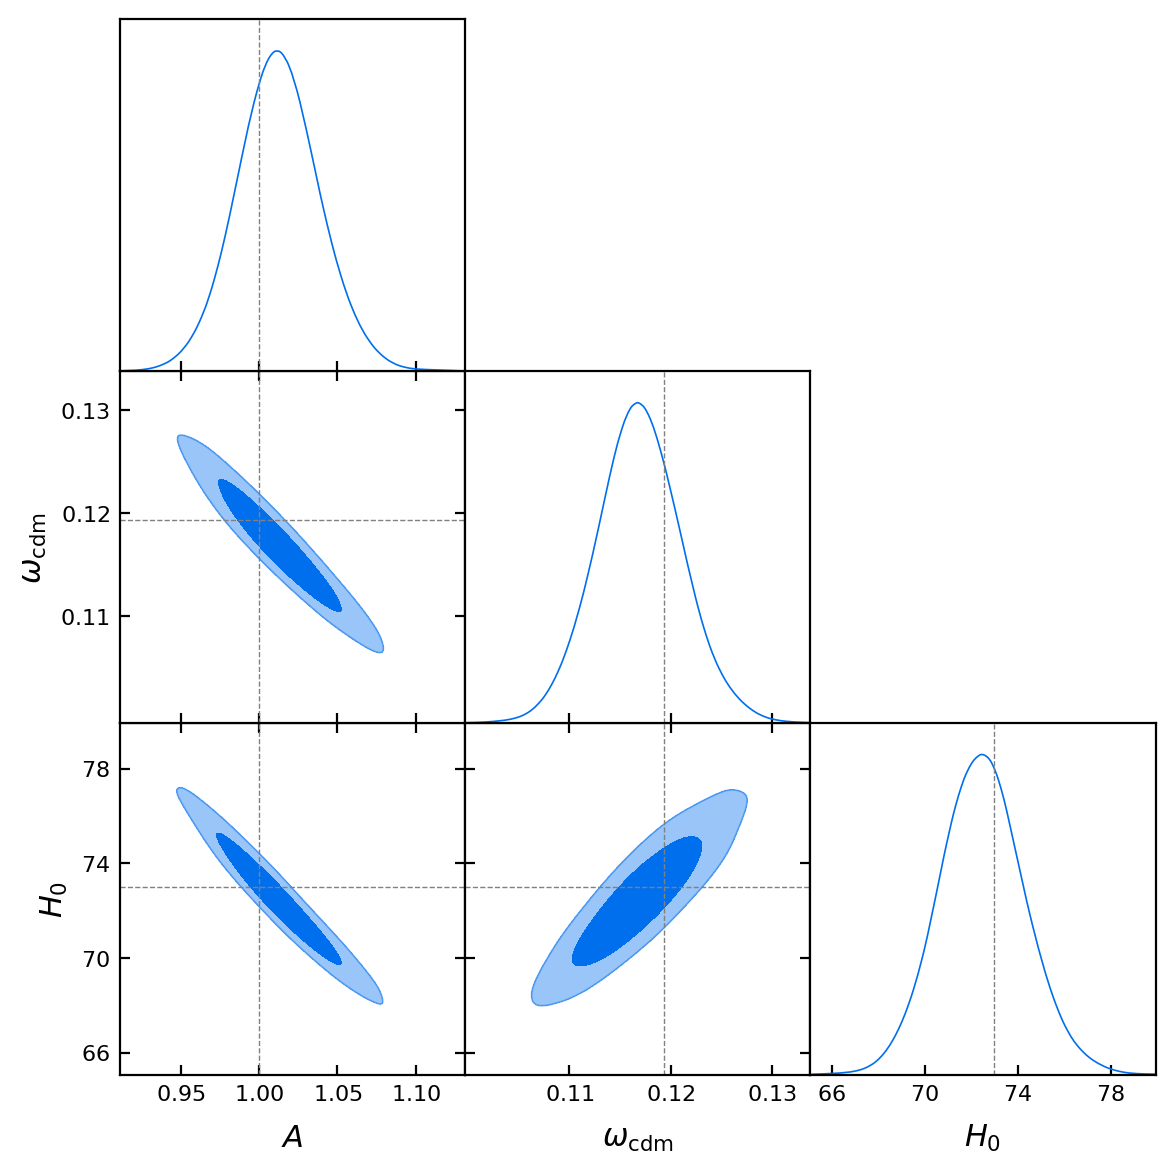

In [9]:
%matplotlib inline

g = plots.get_subplot_plotter()
g.triangle_plot([plot_samples], 
                filled=True,
                markers={'A':1.0, 'sigma8':0.835, 'oc': 0.11933, 'H0':73.0})